In [996]:
%pip install ipympl
import ipympl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import collections
from scipy.stats import zscore
%matplotlib inline

#add other imports as needed

Note: you may need to restart the kernel to use updated packages.


In [997]:
import os

In [998]:
import platform

# Set file location based on platform. 
platstring = platform.platform()
if ('Darwin' in platstring) or ('macOS' in platstring):
    # macOS 
    data_root = "/Volumes/TReND2024/"
elif 'Windows'  in platstring:
    # Windows (replace with the drive letter of USB drive)
    data_root = "E:/"
elif ('amzn' in platstring):
    # then on Code Ocean
    data_root = "/data/"
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_root = "/media/$USERNAME/TReND2024/"

In [999]:
from allensdk.core.brain_observatory_cache import BrainObservatoryCache

manifest_file = os.path.join(data_root,'allen-brain-observatory/visual-coding-2p/manifest.json')

boc = BrainObservatoryCache(manifest_file=manifest_file)

Use code below to access Neuropixels data set. This is electrophysiological data. It is very similar to the data set we demonstrated, but has important differences, both in the science and in the access methods used in the python tools.

In [1000]:
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

manifest_path = os.path.join(data_root,'allen-brain-observatory/visual-coding-neuropixels/ecephys-cache/manifest.json') 

cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

In [1001]:
areas = boc.get_all_targeted_structures()
areas

['VISal', 'VISam', 'VISl', 'VISp', 'VISpm', 'VISrl']

In [1002]:
cre_lines = boc.get_all_cre_lines()
cre_lines

['Cux2-CreERT2',
 'Emx1-IRES-Cre',
 'Fezf2-CreER',
 'Nr5a1-Cre',
 'Ntsr1-Cre_GN220',
 'Pvalb-IRES-Cre',
 'Rbp4-Cre_KL100',
 'Rorb-IRES2-Cre',
 'Scnn1a-Tg3-Cre',
 'Slc17a7-IRES2-Cre',
 'Sst-IRES-Cre',
 'Tlx3-Cre_PL56',
 'Vip-IRES-Cre']

In [1003]:
imaging_depths = boc.get_all_imaging_depths()
imaging_depths

[175,
 185,
 195,
 200,
 205,
 225,
 250,
 265,
 275,
 276,
 285,
 300,
 320,
 325,
 335,
 350,
 365,
 375,
 390,
 400,
 550,
 570,
 625]

In [1004]:
visual_area = [areas[3]]
cre_line = [cre_lines[1]]
imaging_depth = imaging_depths[:7]

In [1005]:
#create an empty dataframe with colums as areas and index as cre_lines
df = pd.DataFrame(columns=areas,index=cre_line)

#populate the dataframe with the number of experiment containers for each combination
for area in areas:
    exps = boc.get_experiment_containers(targeted_structures=[area],cre_lines=cre_line,imaging_depths=imaging_depth)
    df[area].loc[cre_line] = len(exps)

df['Total'] = df.sum(axis=1).astype(int)

#look at dataframe
print(df)

              VISal VISam VISl VISp VISpm VISrl  Total
Emx1-IRES-Cre     2     1    5    3     2     4     17


In [1006]:
exps = boc.get_experiment_containers(targeted_structures=visual_area,cre_lines=cre_line,imaging_depths=imaging_depth)
pd.DataFrame(exps)

,id,imaging_depth,targeted_structure,cre_line,reporter_line,donor_name,specimen_name,tags,failed
0,517328083,175,VISp,Emx1-IRES-Cre,Ai93(TITL-GCaMP6f),237706,Emx1-IRES-Cre;Camk2a-tTA;Ai93-237706,[Epileptiform Events],False
1,536323956,175,VISp,Emx1-IRES-Cre,Ai93(TITL-GCaMP6f),252174,Emx1-IRES-Cre;Camk2a-tTA;Ai93(MG)-252174,[],False
2,543677425,175,VISp,Emx1-IRES-Cre,Ai93(TITL-GCaMP6f),260936,Emx1-IRES-Cre;Camk2a-tTA;Ai93-260936,[],False


In [1007]:
experiment_container_ids = [exps[0]['id']]

In [1008]:
sessions = boc.get_ophys_experiments(experiment_container_ids=experiment_container_ids, stimuli=['natural_scenes'])
sessions

[{'id': 526928092,
  'imaging_depth': 175,
  'targeted_structure': 'VISp',
  'cre_line': 'Emx1-IRES-Cre',
  'reporter_line': 'Ai93(TITL-GCaMP6f)',
  'acquisition_age_days': 143,
  'experiment_container_id': 517328083,
  'session_type': 'three_session_B',
  'donor_name': '237706',
  'specimen_name': 'Emx1-IRES-Cre;Camk2a-tTA;Ai93-237706',
  'fail_eye_tracking': False}]

In [1009]:
session_id = sessions[0]['id']
session_id

526928092

In [1010]:
data_set = boc.get_ophys_experiment_data(ophys_experiment_id=session_id)

In [1011]:
cell_ids = data_set.get_cell_specimen_ids()
cell_ids.shape

(149,)

In [1012]:
# get the stimulus table for the natural scenes stimulus
stim_table = data_set.get_stimulus_table('natural_scenes')
stim_table.start

0       16124
1       16132
2       16139
3       16147
4       16154
        ...  
5945    96263
5946    96271
5947    96278
5948    96286
5949    96293
Name: start, Length: 5950, dtype: int64

In [1013]:
# get trial-to-trial dff traces
timestamps, dff = data_set.get_dff_traces()
dff.shape

(149, 114099)

In [1014]:
(stim_table.end-stim_table.start != 7).sum()

234

In [1015]:
stim_start = stim_table.start.min()
stim_end = stim_table.end.max()+1

In [1016]:
dff = dff[:, stim_start:stim_end]
dff.shape

(149, 80178)

In [1017]:
events = boc.get_ophys_experiment_events(ophys_experiment_id=session_id)
events.shape

(149, 114099)

In [1018]:
events = events[:, stim_start:stim_end]
events.shape

(149, 80178)

In [1019]:
stim_table.end = stim_table.end - stim_start
stim_table.start = stim_table.start - stim_start

In [1020]:
stim_table

,frame,start,end
0,8,0,7
1,110,8,15
2,117,15,22
3,105,23,30
4,57,30,37
...,...,...,...
5945,58,80139,80146
5946,87,80147,80154
5947,4,80154,80161
5948,9,80162,80169


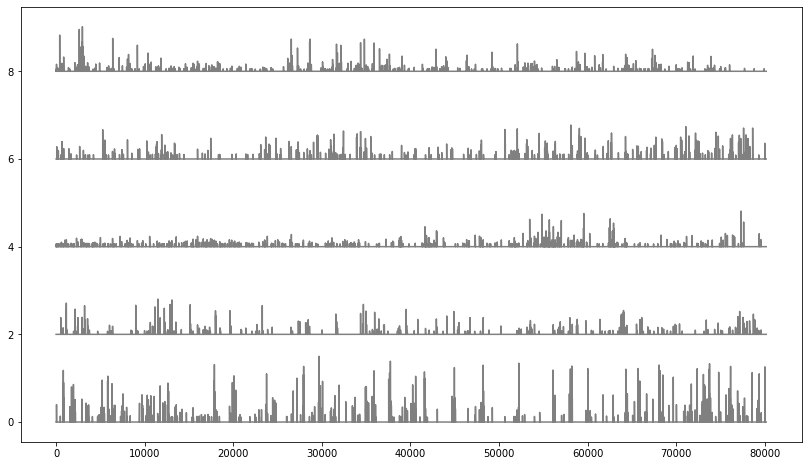

In [1021]:
fig = plt.figure(figsize=(14,8))
for i in range(5):
    plt.plot(events[i,:]+(i*2), color='gray')

In [1022]:
averaging_indices = stim_table.end.to_numpy()
averaging_indices.shape

(5950,)

In [1023]:
cum_events = events.cumsum(axis=1)[:,averaging_indices]
trial_responses = np.c_[cum_events[:,1] ,np.diff(cum_events, axis=1)]/(stim_table.end.to_numpy()-stim_table.start.to_numpy())
trial_responses.shape

(149, 5950)

In [1024]:
# plt.plot(stim_table.end,np.ones(stim_table.end.shape), 'o')

In [1025]:
neural_data = trial_responses.T

In [1026]:
neural_data.mean(axis=1).shape

(5950,)

In [1027]:
neural_data[neural_data != 0].shape

(32926,)

(array([131.,   7.,   3.,   1.,   2.,   0.,   2.,   1.,   1.,   1.]),
 array([0.        , 0.01141455, 0.02282909, 0.03424364, 0.04565819,
        0.05707274, 0.06848728, 0.07990183, 0.09131638, 0.10273092,
        0.11414547]),
 <BarContainer object of 10 artists>)

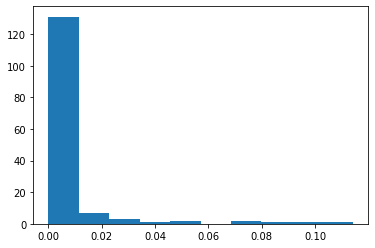

In [1028]:
plt.hist(neural_data[1])

Text(0.5, 1.0, 'Heat map of neural population spike counts')

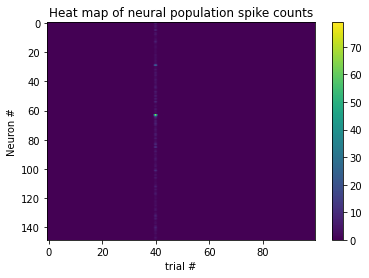

In [1029]:
fig = plt.figure()
b = plt.imshow(neural_data[3800:3900,:].T, aspect='auto')
fig.colorbar(b)
# plt.xticks(averaging_indices,averaging_indices)
plt.ylabel('Neuron #')
plt.xlabel('trial #')
plt.title('Heat map of neural population spike counts')

In [1030]:
# first find the mean of the data
mu = np.mean(neural_data,axis=0)

# now compute the data covariance
# don't forget to center your data first!
neural_data_centered = neural_data - mu

# now you can compute the covariance
cov = (1/neural_data.shape[0]) * neural_data_centered.T @ neural_data_centered
diff = cov - np.cov(neural_data_centered.T)
print("max relative error of cov = " + str(diff.max()/cov.flatten()[diff.argmax()]))

# perform the eigendecomposition of the data covariance
D, U = np.linalg.eig(cov) # D = vector of eigenvalues, U = eigenvectors matrix

# make sure the eigenvalues are sorted (in descending order)
indx = np.argsort(D)[::-1]
D = D[indx]

# arrange the eigenvectors according to the magnitude of the eigenvalues
U = U[:,indx]

max relative error of cov = -0.0001680954782331831


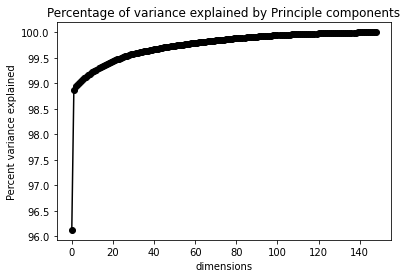

In [1031]:
percent_vars = 100 * D.cumsum() / D.sum()

fig = plt.figure()
plt.plot(percent_vars,'-o',color='k')
plt.xlabel('dimensions')
plt.ylabel('Percent variance explained')
plt.title('Percentage of variance explained by Principle components')
plt.show()

In [1032]:
k=2
latent_data = neural_data @ U[:,:k]
latent_data.shape

(5950, 2)

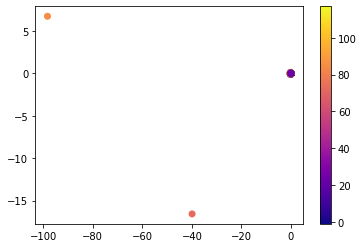

In [1033]:
# fig = plt.figure()
# ax= fig.add_subplot(projection='3d')
plt.scatter(latent_data[:,0], latent_data[:,1], c=stim_table.frame, cmap="plasma")
plt.colorbar()

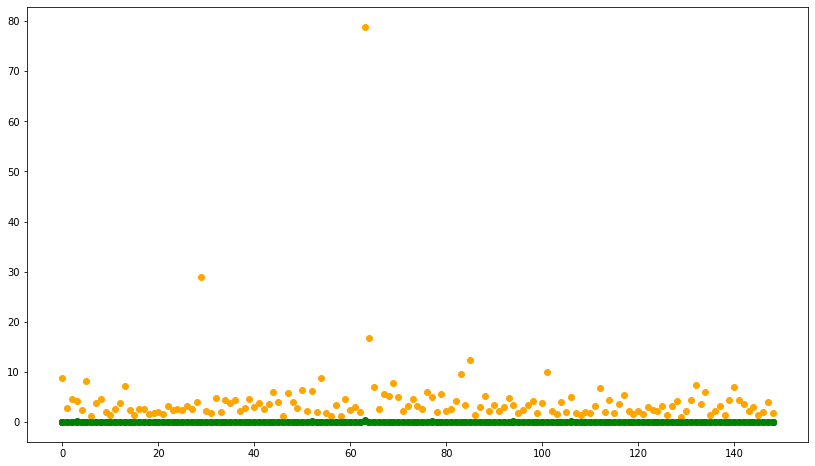

In [1034]:
fig = plt.figure(figsize=(14,8))
# for i in range(1):
#     plt.plot(stim_table.end,p.zeros(stim_table.end.shape), 'o', color='grey')
for i in range(5):
    if i == 0:
        plt.plot(trial_responses[:,3840+i], 'o', color='orange')
    else:
        plt.plot(trial_responses[:,3840+i], 'o', color='g')
# plt.plot(events[i,:], color='b')

In [1035]:
trial_responses_df = pd.DataFrame(trial_responses.mean(axis=0))
print(trial_responses_df.shape)
# Calculate the Z-score for each data point
z_scores = trial_responses_df.apply(zscore)
# Identify rows with any outlier (Z-score > 3 or Z-score < -3)
outliers = (trial_responses_df[(z_scores > 3) | (z_scores < -3)].to_numpy() > 0).nonzero()[0]
outliers

(5950, 1)


array([1920, 3840])

rm outliers

In [1036]:
trial_responses = np.delete(trial_responses, outliers, axis=1)
trial_responses.shape

(149, 5948)

In [1037]:
frames = stim_table['frame'].to_numpy()
frames = np.delete(frames, outliers)
frames.shape

(5948,)

In [1038]:
sorting_indices = np.argsort(frames)
sorted_events = trial_responses[:,sorting_indices]
sorted_events.shape

(149, 5948)

In [1039]:
num_trials_per_stim = np.fromiter(collections.Counter(np.sort(frames)).values(), dtype=float)
num_trials_per_stim.shape

(119,)

In [1040]:
averaging_indices = num_trials_per_stim.cumsum().astype('int') - 1
averaging_indices.shape

(119,)

In [1041]:
cum_trial_responses = sorted_events.cumsum(axis=1)[:,averaging_indices]
stimulus_responses = np.c_[cum_trial_responses[:,1] ,np.diff(cum_trial_responses, axis=1)]/num_trials_per_stim
stimulus_responses.shape

(149, 119)

### Trials


In [1042]:
stimulus_responses = stimulus_responses.T
stimulus_responses.shape

(119, 149)

Text(0.5, 1.0, 'Heat map of neural population spike counts')

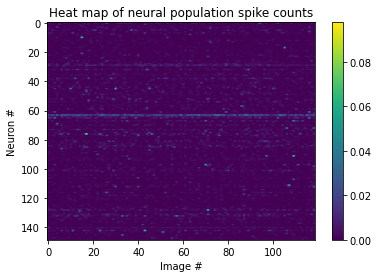

In [1043]:
fig = plt.figure()
b = plt.imshow(stimulus_responses.T, aspect='auto')
fig.colorbar(b)
# plt.xticks(averaging_indices,averaging_indices)
plt.ylabel('Neuron #')
plt.xlabel('Image #')
plt.title('Heat map of neural population spike counts')

In [1044]:
# first find the mean of the data
mu = np.mean(stimulus_responses,axis=0)

# now compute the data covariance
# don't forget to center your data first!
stimulus_responses_centered = stimulus_responses - mu

# now you can compute the covariance
cov = (1/stimulus_responses.shape[0]) * stimulus_responses_centered.T @ stimulus_responses_centered
diff = cov - np.cov(stimulus_responses_centered.T)
print("max relative error of cov = " + str(diff.max()/cov.flatten()[diff.argmax()]))

# perform the eigendecomposition of the data covariance
D, U = np.linalg.eig(cov) # D = vector of eigenvalues, U = eigenvectors matrix

# make sure the eigenvalues are sorted (in descending order)
indx = np.argsort(D)[::-1]
D = D[indx]

# arrange the eigenvectors according to the magnitude of the eigenvalues
U = U[:,indx]

max relative error of cov = -0.00847457627118662


/opt/conda/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


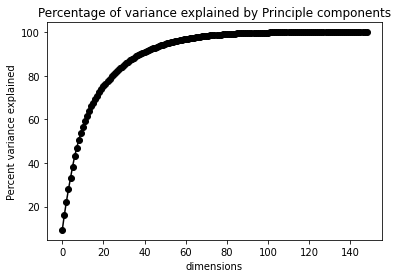

In [1045]:
percent_vars = 100 * D.cumsum() / D.sum()

fig = plt.figure()
plt.plot(percent_vars,'-o',color='k')
plt.xlabel('dimensions')
plt.ylabel('Percent variance explained')
plt.title('Percentage of variance explained by Principle components')
plt.show()

In [1046]:
k=3
latent_data = stimulus_responses @ U[:,:k]
latent_data.shape

(119, 3)

/opt/conda/lib/python3.8/site-packages/matplotlib/collections.py:192: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


Text(0.5, 0.92, 'Stimulus response data projected into three-dimensional PC space')

/opt/conda/lib/python3.8/site-packages/matplotlib/collections.py:551: ComplexWarning: Casting complex values to real discards the imaginary part
  (np.asanyarray(self.convert_xunits(offsets[:, 0]), float),
/opt/conda/lib/python3.8/site-packages/matplotlib/collections.py:552: ComplexWarning: Casting complex values to real discards the imaginary part
  np.asanyarray(self.convert_yunits(offsets[:, 1]), float)))
/opt/conda/lib/python3.8/site-packages/matplotlib/colors.py:389: ComplexWarning: Casting complex values to real discards the imaginary part
  c = tuple(map(float, c))


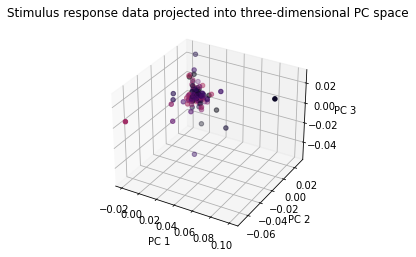

In [1047]:
fig = plt.figure()
ax  = fig.add_subplot(projection='3d')

ax.scatter(latent_data[:,0], latent_data[:,1],  latent_data[:,2], 'o', color=plt.cm.inferno.colors[:latent_data.shape[0]])

ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')

plt.title('Stimulus response data projected into three-dimensional PC space')


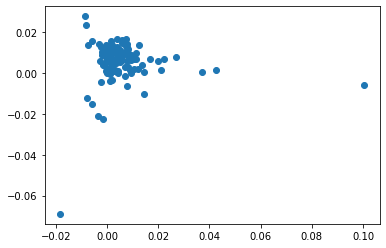

In [1048]:
# fig = plt.figure()
# ax= fig.add_subplot(projection='3d')
plt.scatter(latent_data[:,0], latent_data[:,1])